<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Tarea Semanal 5
#### Fernando Coda
  
## Estimación espectral. Método de Welch y de Blackman Tukey (Correlograma)

---
En esta tarea continuaremos con el capítulo 14 de Holton. DSP Principles and App. y el 8 de Hayes.

Para ello, realizaremos el punto 4 del TP3.

4) Evalue el siguiente estimador de frecuencia de una senoidal contaminada por ruido incorrelado.

Para una señal
$$\large
x(k)=a_1 \cdot \sin(\Omega_1 \cdot k) + n(k)
$$

siendo 

$$
\Omega_1 = \Omega_0 + f_r \cdot \frac{2 \pi}{N}
$$

$$
\Omega_0 = \frac{\pi}{2}
$$

y las variables aleatorias definidas por

$$
f_r \sim \mathcal{U}(−\frac{1}{2}, \frac{1}{2})
$$

$$
n \sim \mathcal{N}(0, \sigma^2)
$$

Evalúe el siguiente estimador de $\Omega_1$

$$
\hat{\Omega}_1^W = \underset{f}{arg\ max} \{\hat{P}_{W}\}
$$

basado en el periodograma de Welch. 

Del mismo modo, evalúe **otro estimador** de la PSD (p.ej. Blackman-Tukey Hayes 8.2.6) para crear otro estimador de $\Omega_1$ definido

$$
\hat{\Omega}_1^X = \underset{f}{arg\ max} \{\hat{P}_{X}\}
$$


Siguiendo las siguientes consignas:

- Considere 200 realizaciones de 1000 muestras para cada experimento.
- Parametrice para SNR's de 3 y 10 dB.

Considere 200 realizaciones de 1000 muestras para cada experimento. Cada realización debe tener un SNR tal que el pico de la senoidal esté 3 y 10 dB por encima del piso de ruido impuesto por n(k).

In [1]:
import numpy  as np
from matplotlib import pyplot as plt
from scipy import signal
from pandas import DataFrame
from IPython.display import HTML


def periodogram_welch(x_t, fs, window):
    N = len(x_t)
    L = N//5
    D = L//2 # 50% overlap
    
    f,Pxx = signal.welch(x_t,
                         fs=fs,
                         window=window,
                         nperseg=L,
                         noverlap=D,
                         nfft=N,
                         average='median',
                         axis=0 
                        )
    Pxx[ 0] = Pxx[ 1]
    Pxx[-1] = Pxx[-2]
    return f, Pxx


def blackman_tukey(x, fs, window, M = None):
    N,R,Z = x.shape
    delta_f = fs/N
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1
    
    w = signal.windows.get_window(window, r_len)
    
    Px = np.zeros_like(x)

    for j in range(Z):
        for i in range(R):
            # hay que aplanar los arrays por np.correlate.
            # usaremos el modo same que simplifica el tratamiento
            # de la autocorr
            xx = x[:,i,j].ravel()[:r_len];
        
            r = np.correlate(xx, xx, mode='same') / r_len
    
            Px[:,i,j] = np.abs(np.fft.fft(r * w, n = N) ) / N

    f  = np.arange(start = 0, stop = N, step = delta_f)
    
    return f, Px;


def graficar_espectro(ax, f, X_f, fs, *args, **kwargs):   
    bfrec = (f <= fs/2)
    X_f = 20 * np.log10(np.abs(X_f)) # Lo paso a dB
    return ax.plot(f[bfrec], X_f[bfrec], *args, **kwargs);

In [2]:
# Generación de la señal de prueba

R = 200  # 200 repeticiones o realizaciones
N = 1000 # nº de muestras

# frec. de sampling normalizada
fs = N
delta_f = fs/N

# Desplazamiento en frecuencia de cada realización
fr = np.random.uniform(-1/2, 1/2, size=(1,R,1))

# Frecuencia central normalizada: pi/2 - es equivalente a fs/4
W0 = fs/4
W1 = W0 + fr

# Valores de SNR a evaluar
snr_dB = np.array([ 3., 10. ], dtype=np.float64)
# Nivel de potencia de ruido para dichos SNR
var_noise  = 10 ** (snr_dB / (-10))
# Señal de ruido
noise = np.random.normal(loc=0.0, scale=np.sqrt(var_noise), size=(N,R,2))

# Amplitud para potencia normalizada
a1 = np.sqrt(2)

# Vector de muestras
end = N / fs
n = np.linspace(start=0, stop=end, num = N, endpoint = False).reshape((N,1,1))

# Señal final
x  = a1 * np.sin(2*np.pi * W1 * n) + noise

In [3]:
# Espectros
window='bartlett'
f,  X_welch_f = periodogram_welch(x, fs, window=window)
f2, X_BT_f = blackman_tukey(x, fs, window=window)

Utilizamos como estimador de frecuencia el valor máximo en los periodogramas

In [4]:
# Estimacion de frecuencia W1
W1_est_welch = f[  np.argmax(X_welch_f [f  <= fs/2], axis=0) ]
W1_est_BT    = f2[ np.argmax(X_BT_f    [f2 <= fs/2], axis=0) ]

W1_est_welch_median = np.median(W1_est_welch, axis=0)
W1_est_welch_bias   = W1_est_welch_median - np.median(W1)
W1_est_welch_var    = np.var(W1_est_welch, axis=0)

W1_est_BT_median = np.median(W1_est_BT, axis=0)
W1_est_BT_bias   = W1_est_BT_median - np.median(W1)
W1_est_BT_var    = np.var(W1_est_BT, axis=0)

A continuación graficamos los espectros obtenidos, aproximados con el periodograma de Welch y el de Blackman-Tukey.

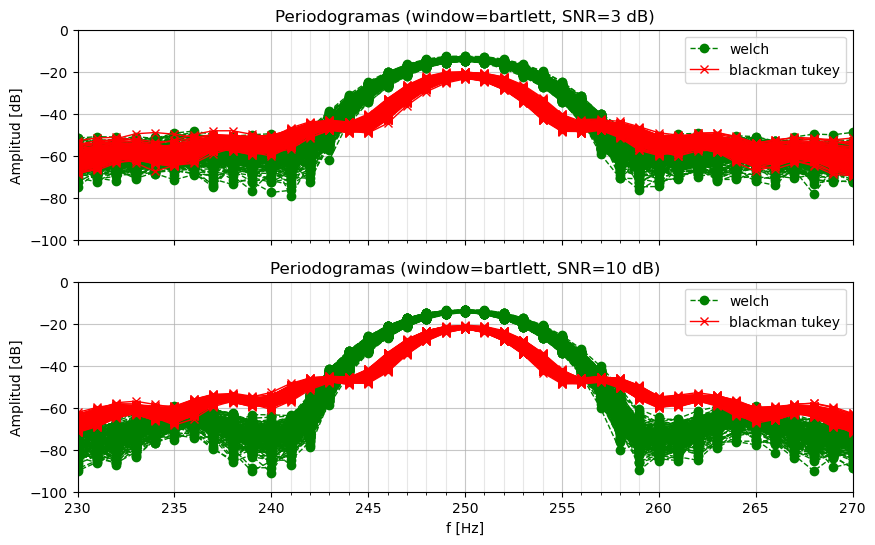

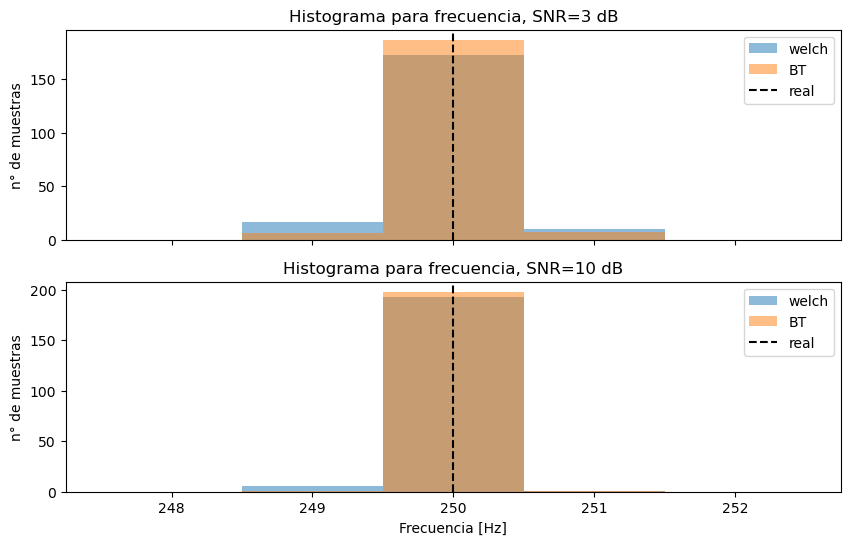

In [5]:
fig = plt.figure(1)
axis = fig.subplots(2,1, sharex=True)

for i, ax in enumerate(axis):
    ax.set_xticks(np.arange(W0-10, W0+10+1), minor=True)
    ax.grid(which='major', alpha=0.7)
    ax.grid(which='minor', alpha=0.3)
        
    *line, = graficar_espectro(ax, f, X_welch_f[:,:,i], fs, 'o--g', linewidth=1)
    line[0].set_label('welch')
    
    *line, = graficar_espectro(ax, f2, X_BT_f[:,:,i], fs, 'x-r', linewidth=1)
    line[0].set_label('blackman tukey')
    
    ax.set_title('Periodogramas (window='+window+', SNR='+str(int(snr_dB[i]))+' dB)')
    ax.set_ylabel('Amplitud [dB]')
    ax.legend()
    ax.set_ylim([-100,  0])

axis[0].set_xlim([W0-20, W0+20])
axis[1].set_xlabel('f [Hz]')
fig.set_figheight(6)
fig.set_figwidth(10)

#-------------------------------------------------------------------------------

nbins = 5; rang = (W0-2.5,W0+2.5); alpha = 0.5

fig = plt.figure(2)
fig.clf()
axis = fig.subplots(2,1, sharex=True)

for i, ax in enumerate(axis):
    ax.hist(W1_est_welch[:,i], bins=nbins, range=rang, alpha=alpha, label='welch', align='mid')
    ax.hist(W1_est_BT[:,i],    bins=nbins, range=rang, alpha=alpha, label='BT',    align='mid')
    ax.axvline(W0, linestyle='--', color='black', label='real')
    ax.set_title('Histograma para frecuencia, SNR='+str(int(snr_dB[i]))+' dB')
    ax.set_ylabel('n° de muestras')
    ax.legend();

ax.set_xlabel('Frecuencia [Hz]')
fig.set_figheight(6)
fig.set_figwidth(10)

#-------------------------------------------------------------------------------

Como indicador utilizaremos directamente la variabilidad, o varianza normalizada.  

Este indicador, junto con la figura de mérito (ambos descriptos en el capítulo 8.2.7 del Hayes), dan una idea del rendimiento de cada estimador.  

Valores menores son mejores.

In [6]:
# Cálculo de indicadores
variability_welch = W1_est_welch_var / (W1_est_welch_median**2)
variability_BT    = W1_est_BT_var    / (W1_est_BT_median**2)

variability = np.array((variability_welch, variability_BT)).T

df = DataFrame(variability, columns=['$i_{W}$', '$i_{BT}$'],
                index=[
                          '3 dB',
                          '10 dB',
                      ])

HTML(df.to_html(classes="table",justify="center"))

,$i_{W}$,$i_{BT}$
3 dB,2.140400e-06,1.039600e-06
10 dB,5.500000e-07,1.600000e-07
